In [1]:
import os
import pandas as pd

base_folder="."

classes=['Canon','Epson','Hp']

data=[]

for cls in classes:
    folder=os.path.join(base_folder,cls)
    
    for img in os.listdir(folder):
        img_path=os.path.join(folder,img)
        
        data.append([img_path,cls.lower()])
        
df=pd.DataFrame(data,columns=['Image','Brand'])
    

In [2]:
df_suffle=df.sample(frac=1).reset_index(drop=True)
df_suffle.head(10)

,Image,Brand
0,.\Epson\c6_58.tif,epson
1,.\Canon\c5_17.tif,canon
2,.\Canon\c2_27.tif,canon
3,.\Epson\c7_11.tif,epson
4,.\Epson\c8_6.tif,epson
5,.\Epson\s7_35.tif,epson
6,.\Epson\s10_31.tif,epson
7,.\Epson\c10_30.tif,epson
8,.\Epson\s10_14.tif,epson
9,.\Hp\s11_87.tif,hp


In [29]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model


In [30]:
train_df, val_df = train_test_split(
    df_suffle,
    test_size=0.2,
    random_state=42,
    stratify=df_suffle['Brand']
)


In [31]:
IMG_SIZE = 224
BATCH_SIZE = 16

train_data = ImageDataGenerator(
    rescale=1./255,
    rotation_range=2,
    brightness_range=[0.9, 1.1]
)

val_data = ImageDataGenerator(
    rescale=1./255
)


In [32]:
train_generator = train_data.flow_from_dataframe(
    train_df,
    x_col="Image",
    y_col="Brand",
    target_size=(IMG_SIZE, IMG_SIZE),
    color_mode="rgb",
    batch_size=BATCH_SIZE,
    shuffle=True
)

val_generator = val_data.flow_from_dataframe(
    val_df,
    x_col="Image",
    y_col="Brand",
    target_size=(IMG_SIZE, IMG_SIZE),
    color_mode="rgb",
    batch_size=BATCH_SIZE,
    shuffle=False
)



Found 928 validated image filenames belonging to 3 classes.
Found 232 validated image filenames belonging to 3 classes.


In [42]:
base_model=MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(IMG_SIZE,IMG_SIZE,3)
)

base_model.trainable=False
x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dense(128,activation='relu')(x)
x=Dropout(0.3)(x)
output=Dense(3,activation='softmax')(x)

model=Model(inputs=base_model.input,outputs=output)

In [43]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [44]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20
)


Epoch 1/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 69s 1s/step - accuracy: 0.4552 - loss: 1.1151 - val_accuracy: 0.7414 - val_loss: 0.5344
Epoch 2/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 60s 959ms/step - accuracy: 0.6407 - loss: 0.7262 - val_accuracy: 0.7931 - val_loss: 0.5097
Epoch 3/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 61s 961ms/step - accuracy: 0.6681 - loss: 0.6728 - val_accuracy: 0.7284 - val_loss: 0.5746
Epoch 4/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 61s 957ms/step - accuracy: 0.6988 - loss: 0.6405 - val_accuracy: 0.8017 - val_loss: 0.4472
Epoch 5/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 60s 949ms/step - accuracy: 0.6632 - loss: 0.6350 - val_accuracy: 0.7629 - val_loss: 0.5126
Epoch 6/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 61s 961ms/step - accuracy: 0.7017 - loss: 0.5912 - val_accuracy: 0.8103 - val_loss: 0.4698
Epoch 7/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 60s 947ms/step - accuracy: 0.7412 - loss: 0.5699 - val_accuracy: 0.8319 - val_loss: 0.4112
Epoch 8/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 60s 950ms/step - accuracy: 0.7525 - loss: 0.5491 - val_accurac

In [45]:
train_df,temp_df=train_test_split(
    df_suffle,
    test_size=0.4,         
    stratify=df_suffle['Brand'],
    random_state=42
)

val_df,test_df= train_test_split(
    temp_df,
    test_size=0.5,
    stratify=temp_df['Brand'],
    random_state=42
)

In [46]:
test_generator=val_data.flow_from_dataframe(
    test_df,
    x_col="Image",
    y_col="Brand",
    target_size=(224,224),
    color_mode="rgb",
    batch_size=16,
    shuffle=False
)


Found 232 validated image filenames belonging to 3 classes.


In [47]:
test_loss,test_accuracy=model.evaluate(test_generator)
print("test_accuracy",test_accuracy)

c:\Users\Yatendra Pachori\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


15/15 ━━━━━━━━━━━━━━━━━━━━ 8s 540ms/step - accuracy: 0.8625 - loss: 0.3635
test_accuracy 0.8620689511299133


In [48]:
from sklearn.metrics import classification_report,confusion_matrix
import numpy as np
y_true=val_generator.classes
y_pred=np.argmax(model.predict(val_generator),axis=1)

print(classification_report(
    y_true,
    y_pred,
    target_names=val_generator.class_indices.keys()
))

15/15 ━━━━━━━━━━━━━━━━━━━━ 11s 604ms/step
              precision    recall  f1-score   support

       canon       0.81      0.89      0.85        96
       epson       0.86      0.76      0.81        96
          hp       0.93      0.97      0.95        40

    accuracy                           0.85       232
   macro avg       0.87      0.87      0.87       232
weighted avg       0.85      0.85      0.85       232



<Axes: >

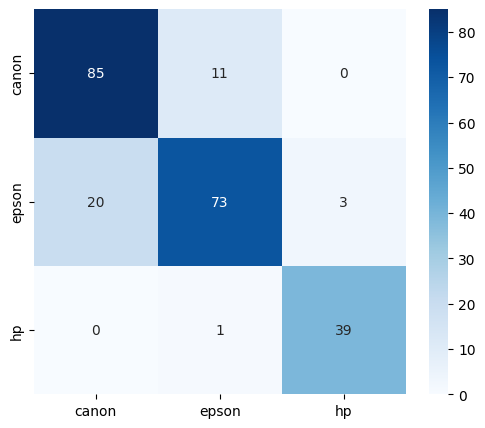

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=val_generator.class_indices.keys(),
    yticklabels=val_generator.class_indices.keys()
)


In [50]:
def grad_cam(model,image_array,last_conv1_layer_name):
    grad_model=Model([model.input],[model.get_layer(last_conv1_layer_name).output,model.output])
    
    
    with tf.GradientTape() as tap:
        conv_o, predictions = grad_model(image_array)
        class_idx = tf.argmax(predictions[0])
        loss = predictions[:, class_idx]

    grads = tap.gradient(loss, conv_o)
    pooled_grads = tf.reduce_mean(grads, axis=(0,1,2))

    conv_o = conv_o[0]
    heatmap = conv_o @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0)
    heatmap /= tf.reduce_max(heatmap)

    return heatmap.numpy()

In [51]:
image_path=val_df.iloc[0]['Image']
imag_load=tf.keras.preprocessing.image.load_img(image_path,target_size=(224,224))
image_array=tf.keras.preprocessing.image.img_to_array(imag_load)
image_array=np.expand_dims(image_array/255.0,axis=0)

heatmap=grad_cam(model,image_array,last_conv1_layer_name='Conv_1')

(-0.5, 1023.5, 1023.5, -0.5)

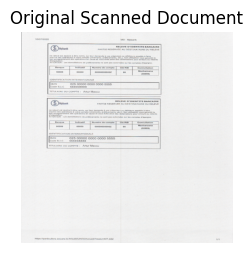

In [52]:
import cv2
original_img=cv2.imread(image_path)
original_img=cv2.cvtColor(original_img,cv2.COLOR_BGR2RGB)
original_img=cv2.resize(original_img,(1024,1024))
plt.figure(figsize=(6,6))
plt.subplot(1,2,1)
plt.imshow(original_img)
plt.title("Original Scanned Document")
plt.axis("off")

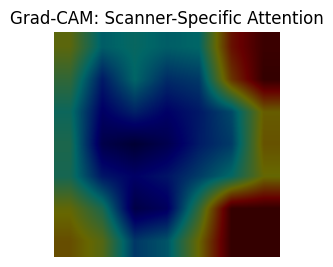

In [53]:
heatmap = cv2.resize(heatmap, (224,224))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

superimposed = heatmap * 0.4 + image_array[0]


plt.subplot(1,2,2)
plt.imshow(superimposed.astype("uint8"))
plt.title("Grad-CAM: Scanner-Specific Attention")

plt.axis("off")

plt.show()
